In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
from Data.Data_Module_CFG import Data_Module_CFG
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
torch.cuda.is_available()

False

In [4]:


class CFG:
    
    device = dev
    
   
    use_wandb = True
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train'
    set_max_label_length = 128
    number_png_images_to_use_in_dataset=20*1000
    labels_transform='default'
    image_transform_name ='alb'
    train_val_fraction = 0.9
    vocabulary_path = 'Tokenizer/230k_ver2.json'
    load_vocabulary = True
    image_padding = True
    max_width = 1000


    batch_size = 8
    num_workers = 0
    on_gpu = False
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 64 // batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate =  1e-5
    eta_min = 1e-8
    t_max = 40
    max_epochs = 35
    weight_decay =  1e-5
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        #A.Resize(patch_size, patch_size),
      
        
     
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        #A.Resize(patch_size, patch_size),
       
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        #A.Resize(patch_size, patch_size),
      

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

In [5]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module_CFG(cfg=CFG
                )


# Generates DataFrame and vocabulary, tokezniers etc
#dataset.prepare_data()

# prepeares the dataloaders with transformations and splits train/val
#dataset.setup(stage = 'train')

Train/Val Data is ready for Model loading.


In [6]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    "\nTrain-Dataset size:", len(dataset.data_train),
    "\nValidation-Dataset size:", len(dataset.data_val),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Train-Dataset size: 156 
Validation-Dataset size: 1 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [7]:
# Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s + str(letter)
    return s





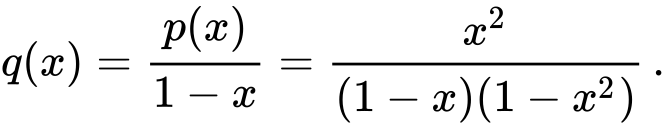

<S>q(x)={\frac{p(x)}{1-x}}={\frac{x^{2}}{(1-x)(1-x^{2})}}\,.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


In [8]:

transform = transforms.ToPILImage()
display(transform(dataset.data_train[1][0]))
print(token_to_strings(dataset.data_train[1][1]))

In [9]:
# Initiate the model
model = ResNetTransformer(dataset=dataset).to(dev)

/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:

logger = TensorBoardLogger("Models_Parameters_Log", name="Test_Run")
lit_model = LitResNetTransformer(model=model)

#use the lit_model to run with Trainer
trainer = Trainer(accelerator="mps",   max_epochs=4, logger=logger,) #accumulate_grad_batches=2, overfit_batches=1, default_root_dir="lightning_logs/ResNet/checkpoints"  
trainer.fit(model=lit_model, datamodule=dataset,)

#add parameter below to trainer.fit to continue from a checkpoint
#ckpt_path='lightning_logs/Character_tokenizer_1/version_2/checkpoints/epoch=0-step=1294.ckpt'
 #ckpt_path='lightning_logs/Character_tokenizer_1/version_4/checkpoints/epoch=15-step=20704.ckpt' )

wandb: Currently logged in as: gmarus. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNetTransformer  | 16.4 M
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | val_cer  | CharacterErrorRate | 0     
3 | test_cer | CharacterErrorRate | 0     
------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.402    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval T

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
